## Prompt Metadata

#### Metadata File to pandas dataframe

In [22]:
from src.utils import read_yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.factories import dataLoaderFactory, teacherResponseParserFactory
from src.teacher_response_evaluator import TeacherResponseEvaluator

In [23]:
def get_meta_df(dataset: str) -> pd.DataFrame:
    metadata = read_yaml(f"prompt-metadata/{dataset}.yaml")

    # flatten metadata and convert to dataframe
    metadata = {k: {**v['costs'], **v['characteristics'], **v['performance']} for k, v in metadata.items()}
    meta_df = pd.DataFrame.from_dict(metadata, orient='index')

    # Add PALM FewShot Performance to meta_df
    # Load PALM predictions and rationales
    dataset_loader = dataLoaderFactory(dataset)
    train_llm_rationales, train_llm_labels = dataset_loader.load_llm_preds(split="train")

    parsed_responses = {i: (label, rational) for i, (label, rational) in enumerate(zip(train_llm_labels, train_llm_rationales))}

    evaluator = TeacherResponseEvaluator(dataset)

    label_eval = evaluator.get_label_accuracy(split="train", parsed_responses=parsed_responses)
    rationale_eval = evaluator.get_explanation_characteristics(parsed_responses=parsed_responses)

    palm_eval = {"accuracy": label_eval[0],
             "n_correct": label_eval[1],
             "n_wrong": label_eval[2],
             "n_none_responses": rationale_eval[0],
             "total_responses": rationale_eval[1],
             "total_length_of_explanations": rationale_eval[2],
             "total_number_of_sentences": rationale_eval[3],
             "total_number_of_words": rationale_eval[4],
             "flesch_reading_ease": rationale_eval[5],
             "variance_length_of_explanations": rationale_eval[6],
             "avg_len_of_explanations": rationale_eval[2] / rationale_eval[1],
             "avg_nr_of_sentences": rationale_eval[3] / rationale_eval[1],
             "avg_nr_of_words": rationale_eval[4] / rationale_eval[1],
             "n_parse_errors": 0,
             }
    
    # insert PALM evaluation into metadata dataframe with index 0
    meta_df = pd.concat([pd.DataFrame(palm_eval, index=[0]), meta_df])

    # add column with explanation rate = total responses / (n_correct + n_wrong)
    meta_df["explanation_rate"] = meta_df["total_responses"] / (meta_df["n_correct"] + meta_df["n_wrong"])

    return meta_df

In [24]:
## Check GPT35 performance on validation set
#test_gpt35_rationales, test_gpt35_labels = dataset_loader.load_gpt35_preds(split="valid", prompt_mix_id=6)
#parsed_responses_gpt35 = {i: (label, rational) for i, (label, rational) in enumerate(zip(test_gpt35_labels, test_gpt35_rationales))}
#evaluator.get_label_accuracy(split="valid", parsed_responses=parsed_responses_gpt35)

In [25]:
meta_df = get_meta_df("cqa")
meta_df.head()

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate
0,0.742634,7234,2507,0,9741,1291860,19502,236371,75.707027,599.220297,...,24.265578,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,0.600000,45,30,75,0,0,0,0,0.000000,NaN,...,0.000000,1,0.00015,33.25,53.35,0.010989,75.0,2494.0,4001.0,0.000000
2,0.706700,53,22,3,72,8953,73,1526,47.100000,1197.477000,...,21.190000,2,0.00015,27.16,63.35,0.011201,75.0,2037.0,4751.0,0.960000
3,0.724000,7052,2689,28,9713,1122684,9726,183730,46.600000,852.771000,...,18.920000,15,0.00018,27.65,84.36,1.993159,10962.0,303054.0,924701.0,0.997126
4,0.720000,54,21,4,71,8104,73,1352,48.000000,1481.135000,...,19.040000,3,0.00018,28.81,78.28,0.013128,75.0,2161.0,5871.0,0.946667


In [26]:
# sort meta_df by accuracy
meta_df.sort_values(by=["accuracy"], ascending=False).head(10)

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate
6,0.770000,77,23,89,11,1054,12,174,51.200000,3666.694000,...,15.820000,2,0.00012,12.75,60.89,0.011683,100.0,1275.0,6089.0,0.110000
20,0.750000,75,25,98,2,194,2,36,0.000000,441.000000,...,18.000000,0,0.00009,5.18,52.89,0.008970,100.0,518.0,5289.0,0.020000
0,0.742634,7234,2507,0,9741,1291860,19502,236371,75.707027,599.220297,...,24.265578,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
3,0.724000,7052,2689,28,9713,1122684,9726,183730,46.600000,852.771000,...,18.920000,15,0.00018,27.65,84.36,1.993159,10962.0,303054.0,924701.0,0.997126
12,0.720000,54,21,69,6,631,6,103,45.000000,1508.139000,...,17.170000,0,0.00009,6.61,53.56,0.007017,75.0,496.0,4017.0,0.080000
73,0.720000,54,21,71,4,885,6,143,41.800000,26846.188000,...,35.750000,5,0.00012,17.45,53.53,0.008640,75.0,1309.0,4015.0,0.053333
27,0.720000,54,21,60,15,2520,21,408,44.400000,5629.200000,...,27.200000,0,0.00012,19.69,53.53,0.008976,75.0,1477.0,4015.0,0.200000
22,0.720000,54,21,71,4,368,4,65,0.000000,1096.500000,...,16.250000,2,0.00009,7.35,51.56,0.006903,75.0,551.0,3867.0,0.053333
15,0.720000,54,21,63,12,1610,15,258,47.500000,4295.472000,...,21.500000,0,0.00011,12.31,57.56,0.008322,75.0,923.0,4317.0,0.160000
14,0.720000,54,21,71,4,298,4,58,0.000000,962.250000,...,14.500000,1,0.00009,6.45,54.56,0.007106,75.0,484.0,4092.0,0.053333


## Plots

Text(0.5, 1.0, 'Variance of Length of Explanations')

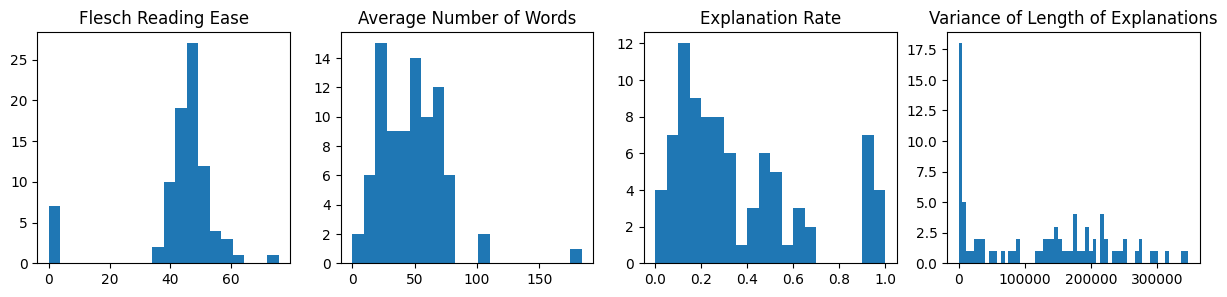

In [27]:
# histograms of: flesh reading ease, avg_nr_of_sentences, avg_nr_of_words, variance_length_of_explanations
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
ax1.hist(meta_df["flesch_reading_ease"], bins=20)
ax1.set_title("Flesch Reading Ease")
ax2.hist(meta_df["avg_nr_of_words"], bins=20)
ax2.set_title("Average Number of Words")
ax3.hist(meta_df["explanation_rate"], bins=20)
ax3.set_title("Explanation Rate")
ax4.hist(meta_df["variance_length_of_explanations"], bins=60)
ax4.set_title("Variance of Length of Explanations")

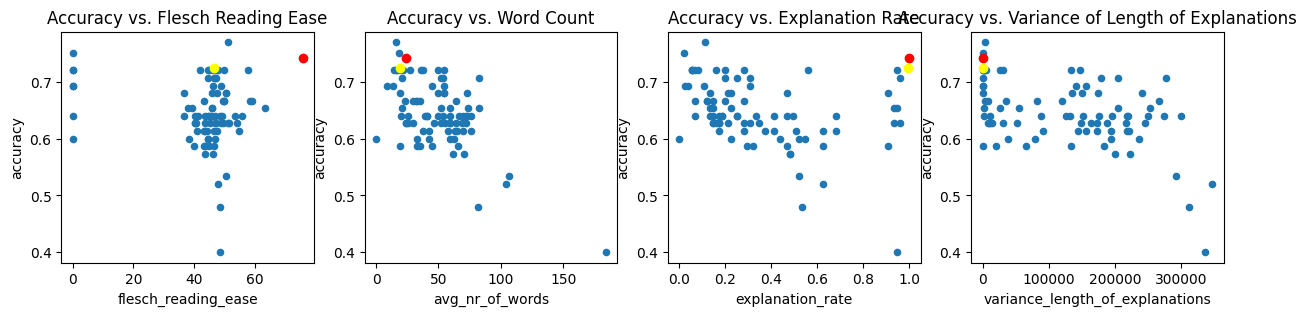

In [29]:
# scatter plots of accuracy vs. flesch reading ease alongside accuracy vs. word count, alongside acc vs. n_responses, alongside acc vs. variance of length of explanations
# collor point with index 0 red to indicate PALM
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
meta_df.plot.scatter(x="flesch_reading_ease", y="accuracy", title="Accuracy vs. Flesch Reading Ease", ax=ax1)
meta_df.plot.scatter(x="avg_nr_of_words", y="accuracy", title="Accuracy vs. Word Count", ax=ax2)
meta_df.plot.scatter(x="explanation_rate", y="accuracy", title="Accuracy vs. Explanation Rate", ax=ax3)
meta_df.plot.scatter(x="variance_length_of_explanations", y="accuracy", title="Accuracy vs. Variance of Length of Explanations", ax=ax4)

HIGHLIGHT = 3
ax1.scatter(meta_df.iloc[0]['flesch_reading_ease'], meta_df.iloc[0]['accuracy'], color='red')
ax1.scatter(meta_df.iloc[HIGHLIGHT]['flesch_reading_ease'], meta_df.iloc[HIGHLIGHT]['accuracy'], color='yellow')
ax2.scatter(meta_df.iloc[0]['avg_nr_of_words'], meta_df.iloc[0]['accuracy'], color='red')
ax2.scatter(meta_df.iloc[HIGHLIGHT]['avg_nr_of_words'], meta_df.iloc[HIGHLIGHT]['accuracy'], color='yellow')
ax3.scatter(meta_df.iloc[0]['explanation_rate'], meta_df.iloc[0]['accuracy'], color='red')
ax3.scatter(meta_df.iloc[HIGHLIGHT]['explanation_rate'], meta_df.iloc[HIGHLIGHT]['accuracy'], color='yellow')
ax4.scatter(meta_df.iloc[0]['variance_length_of_explanations'], meta_df.iloc[0]['accuracy'], color='red')
ax4.scatter(meta_df.iloc[HIGHLIGHT]['variance_length_of_explanations'], meta_df.iloc[HIGHLIGHT]['accuracy'], color='yellow')

Good prompts, that deliver the most accurate results, seem to produce short (between 20 and 30 words), high FRE (above 45) explanations.

There seem to be the following tendencies:
 - The lower the FRE, the lower the accuracy. So complicated explanations are not good for the prediction.
 - The longer the explanation, the lower the accuracy. So long explanations are not good for the prediction.
 - However, very short explanations (< 20 words) are also not good for the prediction.
 - Wether a prompt makes the model return an explanation at all, does not seem to have an influence on the accuracy.

<Axes: title={'center': 'Parse Errors vs. Explanation Rate'}, xlabel='explanation_rate', ylabel='n_parse_errors'>

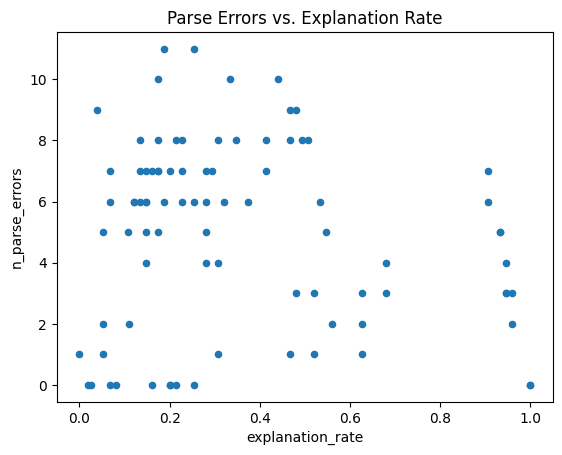

In [20]:
meta_df.plot.scatter(x="explanation_rate", y="n_parse_errors", title="Parse Errors vs. Explanation Rate")

<Axes: title={'center': 'Accuracy vs. Index'}>

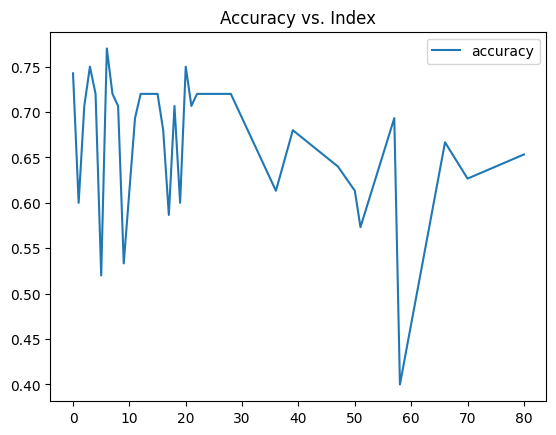

In [21]:
# line plot of accuracy vs index, filtered by n_parse_errors < 10
meta_df[meta_df["n_parse_errors"] < 5].plot.line(y="accuracy", title="Accuracy vs. Index")

<Axes: title={'center': 'Max Accuracy vs. Index'}>

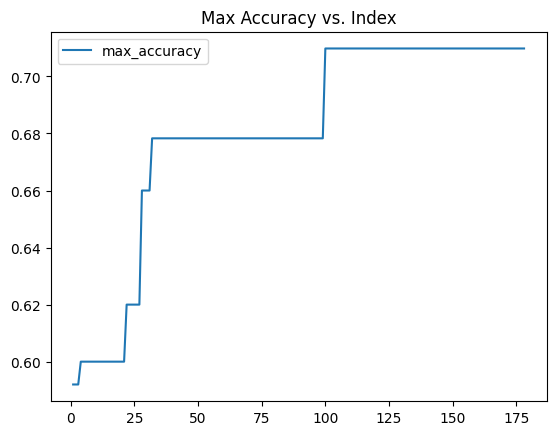

In [69]:
# line plot showing max accuracy so far vs. index, starting from index 1
meta_df["max_accuracy"] = meta_df.drop(0, axis=0)["accuracy"].cummax()
meta_df.plot.line(y="max_accuracy", title="Max Accuracy vs. Index")

In [70]:
meta_df[(meta_df["explanation_rate"] > 0.96) & (meta_df["avg_nr_of_words"] < 30)]

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,variance_length_of_explanations,...,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate,max_accuracy
0,0.709076,12016,4930,0,16946,1925445,25264,326230,63.22534,2689.366852,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,0.592000,74,51,0,125,15470,130,2583,47.30000,1687.254000,...,0,0.00020,30.08,125.28,0.025320,125.0,3760.0,15660.0,1.0,0.5920
2,0.456000,57,68,0,125,21123,137,3396,40.80000,2083.536000,...,0,0.00033,40.82,215.10,0.041242,125.0,5103.0,26887.0,1.0,0.5920
176,0.560000,28,22,0,50,7325,51,1220,43.40000,1695.210000,...,0,0.00030,38.80,151.52,0.015244,50.0,1940.0,7576.0,1.0,0.7098


## Training Results

In [4]:
experiments = pd.read_csv('experiment-tracking/experiment_tracking.csv')
experiments.head()

,experiment_group,category,dataset,model,mode,llm,subsample,prompt_mix,label_type,alpha,max_input_length,batch_size,optimizer,lr,run,train_duration,train_steps,test_acc,eval_acc
0,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.125,0,gt,0.5,1024,64,AdamW,0.00005,0,2528.0,3750.0,0.349,0.347
1,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.250,0,gt,0.5,1024,64,AdamW,0.00005,0,3738.0,5500.0,0.434,0.403
2,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,0.500,0,gt,0.5,1024,64,AdamW,0.00005,0,8497.0,9500.0,0.346,0.342
3,Subsampling ANLI1,standard Finetuning,anli1,t5-v1_1-base,standard,NaN,1.000,0,gt,0.5,1024,64,AdamW,0.00005,0,5848.0,6500.0,0.341,0.334
4,Subsampling ANLI1,step-by-step Finetuning,anli1,t5-v1_1-base,task_prefix,palm,0.125,0,gt,0.5,1024,64,AdamW,0.00005,0,7970.0,5750.0,0.441,0.401


In [6]:
finetuning_subsample = experiments.query("label_type == 'gt'")

In [20]:
filtered_df = finetuning_subsample.query("dataset == 'anli1' and  prompt_mix in [0, 6] and model == 't5-v1_1-base'")

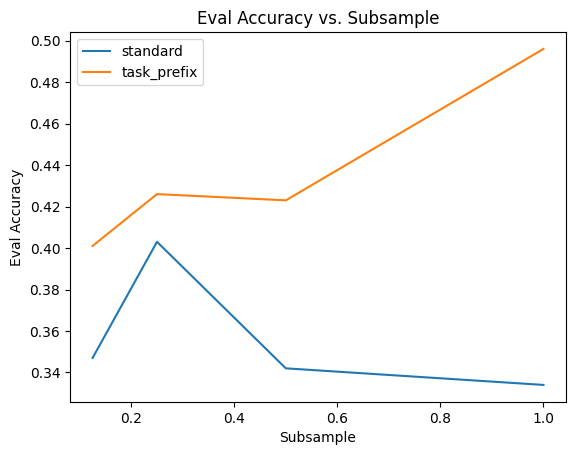

In [21]:
## line plot of eval_acc vs. subsample with two lines, one for mode == standard and one for mode == task_prefix
fig, ax = plt.subplots()
filtered_df[filtered_df["mode"] == "standard"].plot.line(x="subsample", y="eval_acc", ax=ax, label="standard")
filtered_df[filtered_df["mode"] == "task_prefix"].plot.line(x="subsample", y="eval_acc", ax=ax, label="task_prefix")
ax.set_title("Eval Accuracy vs. Subsample")
ax.set_ylabel("Eval Accuracy")
ax.set_xlabel("Subsample")
ax.legend()